# A2 Image Stitching & Object Detection 

Student Name: Irene Huang 

Student ID : 260740689 

## 2 Image Stitching 

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### 1 Compute SIFT keypoints and corresponding descriptors for left and central images.

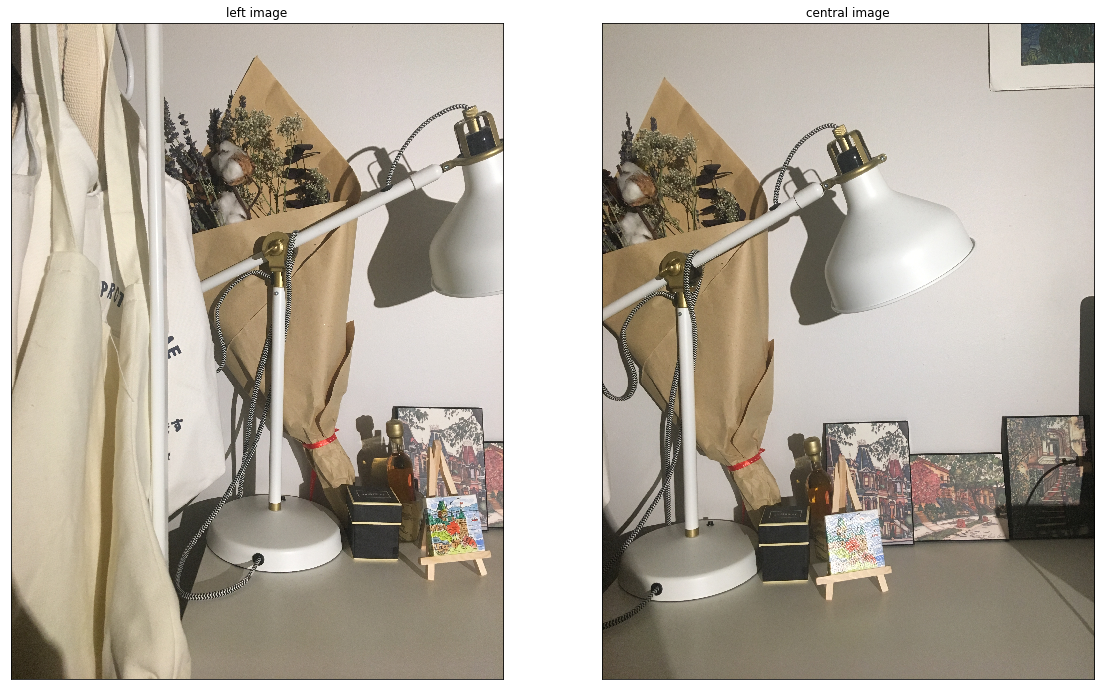

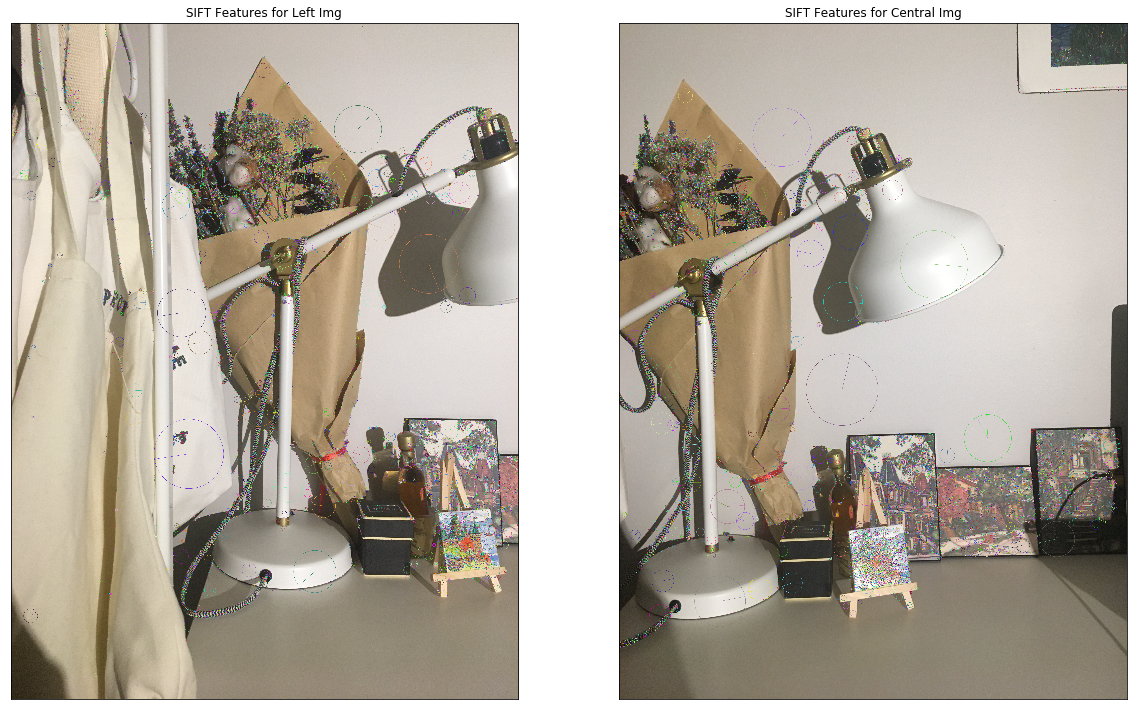

In [3]:
# read images 
img1 = cv2.imread("stitch1.JPG")
img2 = cv2.imread("stitch2.JPG")

imgleft_kp = img1.copy()
imgcenter_kp = img2.copy()


# conversion 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# display original images 
plt.figure(figsize=(30, 30))
plt.subplot(131), plt.imshow(img1)
plt.title("left image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img2)
plt.title("central image"), plt.xticks([]), plt.yticks([])
# plt.subplot(133), plt.imshow(img3)
# plt.title("right image"), plt.xticks([]), plt.yticks([])

# Compute SIFT Keypoints 

# conversion
imgleft_kp = cv2.cvtColor(imgleft_kp, cv2.COLOR_BGR2RGB)
imgcenter_kp = cv2.cvtColor(imgcenter_kp, cv2.COLOR_BGR2RGB)
# imgright_kp = cv2.cvtColor(imgright_kp, cv2.COLOR_BGR2RGB)


# create SIFT objects
sift_obj = cv2.xfeatures2d.SIFT_create() 

# detect SIFT features, compute keypoint. Can pass a mask if want to search only a part of image
# Computer SIFT Descriptor
keypoint_left, descriptors_left = sift_obj.detectAndCompute(img1, None)  
keypoint_central, descriptors_central = sift_obj.detectAndCompute(img2, None)

# draw keypoints on left and central images 
    # draw small circles on the locations of the kepoints 
    # if pass cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, it will draw
    # a circle with size of keypoint and it will show its origintation 
    # ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
cv2.drawKeypoints(img1, keypoint_left, imgleft_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img2, keypoint_central, imgcenter_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imgleft_kp)
plt.title("SIFT Features for Left Img"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgcenter_kp)
plt.title("SIFT Features for Central Img"), plt.xticks([]), plt.yticks([])


# plot 10 SIFT descriptors
num = 10
plt.figure(figsize=(15,5))
for i in range(num):
    plt.bar(np.arange(0,128),descriptors_left[i], edgecolor='k')
    plt.xlim([0,128])
    

plt.figure(figsize=(15,5))
for j in range(num):
    plt.bar(np.arange(0,128),descriptors_central[j], edgecolor='k')
    plt.xlim([0,128])

plt.show()

#### 2 Find matching keypoints in two images and display the 20 best pairs.

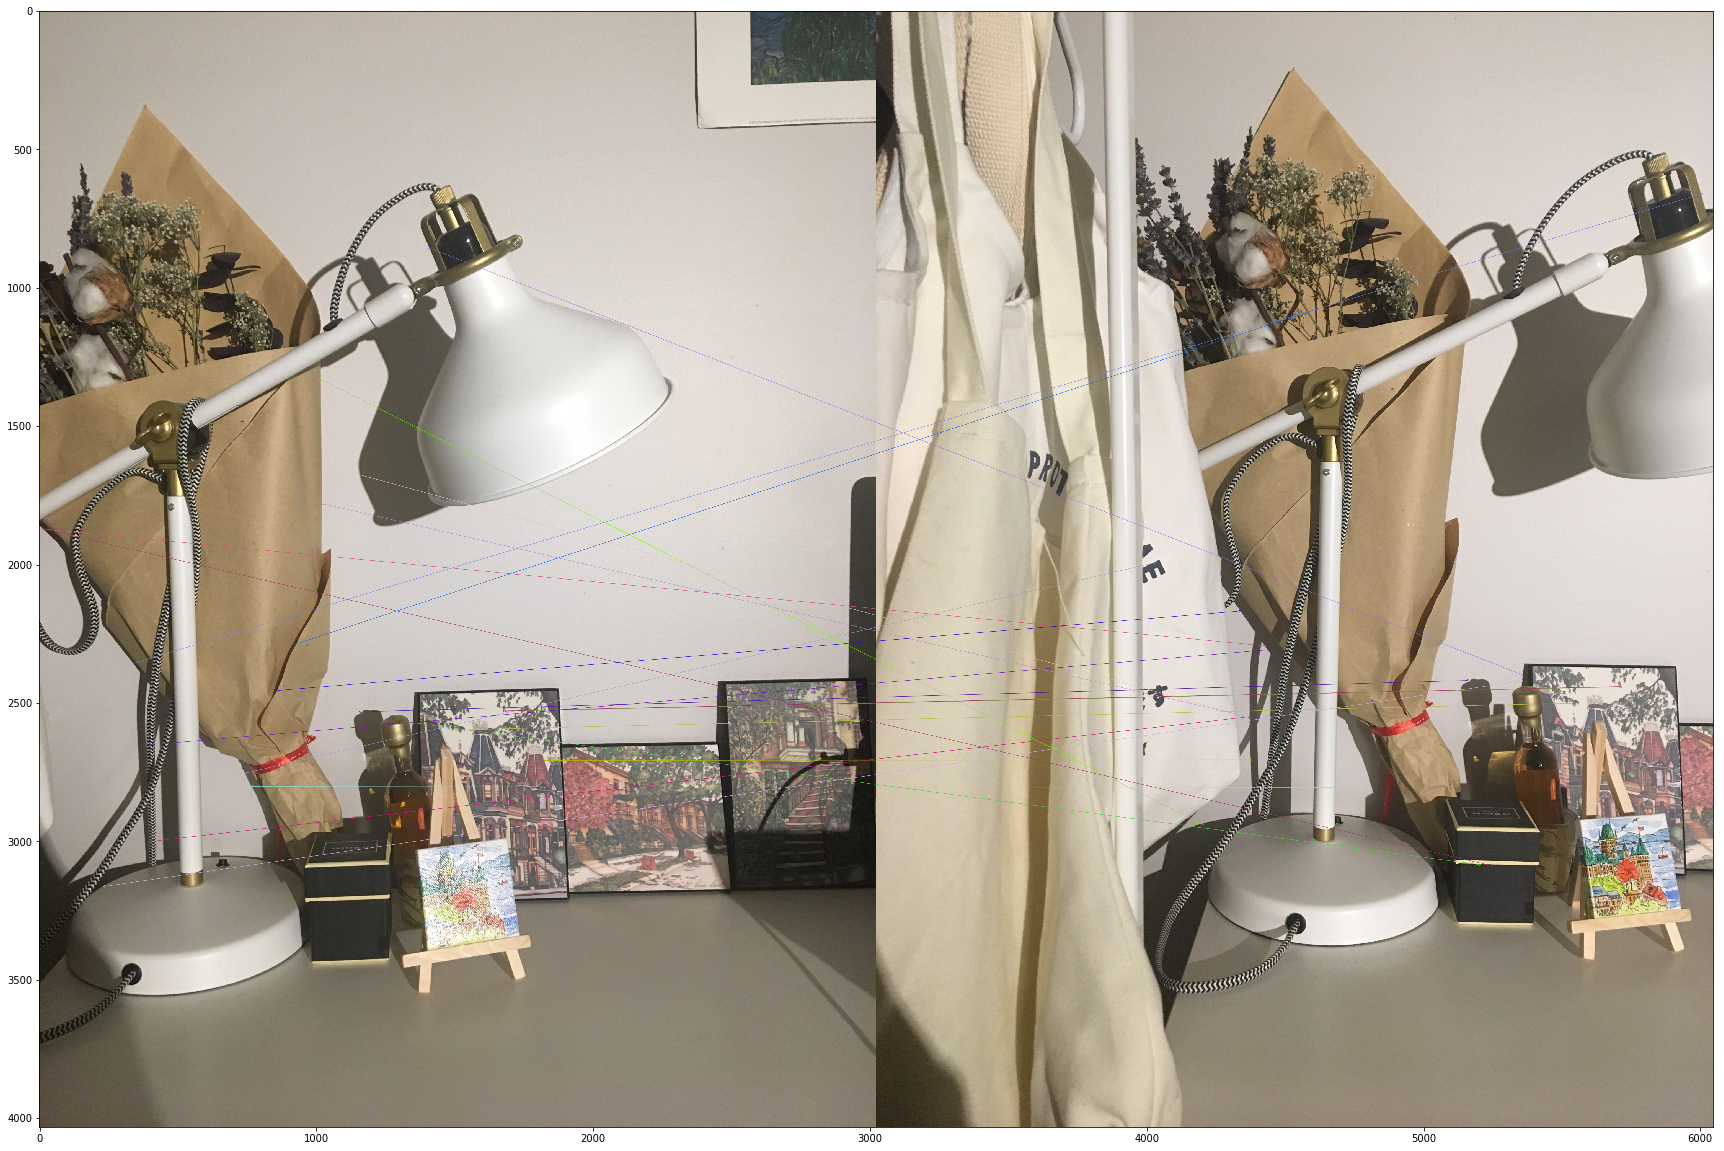

In [4]:
# Create BFMatcher object 

    # cv2.BFMatcher(): For each descriptor in the first set, this matcher finds 
    # the closest descriptor in the second set by trying each one. 
    # This descriptor matcher supports masking permissible matches 
    # of descriptor sets.
    # reference: https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html#details

bf = cv2.BFMatcher() 

# Match descriptors in two images 
matches = bf.match(descriptors_central, descriptors_left)

# Sort matches in distance 
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints on images 

imgMatch = cv2.drawMatches(img2, keypoint_central, img1, keypoint_left, matches[:20], img1, flags=2)

plt.figure(figsize=(30,30))
plt.imshow(imgMatch)
plt.show()




#### 3 Find homography using RANSAC method. Implement RANSAC from scratch. Do not use OpenCV implementation. (6 points)
 – Steps to compute homography using RANSAC are given in Lecture 9 - slide 52.
 
 – Note on step 3: Compute H using opencv function findHomography with method=0.
 
 – Note on step 5: Before computing distance, convert projected key- points from homogeneous to euclidean space using opencv function convertPointsFromHomogeneous.

In [5]:
# TODO 

# Arrange matching keypoints in two lists 
GoodMatches = [] 
for j, k in enumerate(matches): 
    if k.distance < 1000: 
        GoodMatches.append((k.trainIdx, k.queryIdx))

mpc = np.float32([keypoint_central[i].pt for(__, i) in GoodMatches])
mpl = np.float32([keypoint_left[i].pt for(i, __) in GoodMatches])
print(mpc)
print (len(mpc), len(mpl))

# set the number of samples N
numOfSamples = 1 
numMatches = 4
sampleCount = 0
distanceThresh = 3
mpc_inlier = []
mpl_inlier = []
mpc_best_inlier = []
mpl_best_inlier = [] 
numOfInlier = 0
maxInlier = 0

while sampleCount < numOfSamples:  # repeat for N times 
    
    # choose 4 random potential matches 
    random1 = np.random.randint(0, len(mpc))
    random2 = np.random.randint(0, len(mpc))
    random3 = np.random.randint(0, len(mpc))
    random4 = np.random.randint(0, len(mpc))
    array_center = np.array([mpc[random1], mpc[random2],mpc[random3],mpc[random4]]) # choose value in array
    array_left = np.array([mpl[random1], mpl[random2],mpl[random3],mpl[random4]]) 
    print(array_center)
    print(array_left)
    
    # compute H 
    H, mask = cv2.findHomography(array_center, array_left, 0)
    print(H)
    
    # reshape array 
    for i in range (0, len(mpc)): 
        mpc_reshape = ([mpc[i].item(0), mpc[i].item(1), 1])
       
        # project points from x to x' for each potentially matching pair Xi' = HXi
        projectpoints = H.dot(mpc_reshape)  # dot product 
        print(projectpoints)
        
        projectpoints = np.array([projectpoints[0], projectpoints[1], projectpoints[2], 1])
       
        print(projectpoints)
        # convert keypoints to eucliean space 
        estimate_array = cv2.convertPointsFromHomogeneous(projectpoints.reshape(4))
    
        # count points with projected distance < t using a for loop 
        est_x = estimate_array[i].item(0)
        est_y = estimate_array[i].item(1)
        array_left_x = array_left[i].item(0)
        array_left_y = array_left[i].item(1)
        
        # calculate distance 
        distance = np.sqrt(np.square(est_x - array_left_x) + np.square(est_y - array_left_y))
        
        # count inliers
        if distance < distanceThresh:
            mpc_inlier.append(array_center[i])
            mpl_inlier.append(array_left[i])
            numOfInlier = numOfInlier + 1 
            # calculate H using the largest set of inliers 
            finalH = H
            
    # update the best inliers
    if numOfInlier > maxInlier: 
        mpc_best_inlier = mpc_inlier
        mpl_best_inlier = mpl_inlier
        maxInlier = numOfInlier 
        
        
    # reset values 
    numOfInlier = 0 
    mpc_inlier = [] 
    mpl_inlier = [] 
    
    # update the number of samples 
    sampleCount = sampleCount + 1

print(finalH)





[[1680.4397 2528.1086]
 [1159.9255 2531.5498]
 [1025.3068 1779.9249]
 ...
 [2884.2993 2483.507 ]
 [2421.7178 2694.4321]
 [1070.7953 1092.5608]]
22111 22111
[[1583.1002 2946.9224]
 [1399.0933 3056.1274]
 [1501.2192 3306.0684]
 [1657.839  2644.9666]]
[[1686.5743 1296.0956]
 [1544.3883  681.4081]
 [1358.6185  692.6511]
 [1170.9106  758.9355]]
[[-6.52836946e-01 -1.69160382e-01  1.53217567e+03]
 [-2.88737962e-01 -7.63092073e-02  6.82106656e+02]
 [-4.23962022e-04 -1.11549157e-04  1.00000000e+00]]
[7.46672602e+00 3.98195686e+00 5.54900079e-03]
[7.46672602e+00 3.98195686e+00 5.54900079e-03 1.00000000e+00]


error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/calib3d/src/fundam.cpp:923: error: (-215:Assertion failed) npoints >= 0 in function 'convertPointsFromHomogeneous'


#### 4 Apply transformation to left image. Central image should not be trans- formed. You are given a function warpPerspectivePadded. Use this function instead of OpenCV function warpPerspective for image trans- formation.

In [6]:
# import function from another jupyter notebook 
import import_ipynb
import warpPerspectivePadded

# warpPerspectivePadded(imgl, H, imgr_shape)
# image 1
transformed = warpPerspectivePadded(img1, finalH, (img2.shape[1]+img1.shape[1], img2.shape[0])
print(transformed)
                                    
plt.figure(figsize=(30,30))
plt.imshow(transformed), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show() 


NameError: name 'finalH' is not defined

#### 5 Stitch transformed left image and original central image together using pyramid image blending

In [ ]:
# define pyramid_blending function 
# img1: left image 
# img2: right image 
# level: Laplacian level 

def pyramid_blending(img1, img2, level): 
    # generate Gaussian pyramid for img1 and img2
    GA = img1.copy()
    gpA = [GA]
    GB = img2.copy()
    gpB = [GB]
    for i in range(level):
        GA = cv2.pyrDown(GA) # blur image and downsample 
        gpA.append(GA)
        GB = cv2.pyrDown(GB)
        gpB.append(GB)
        
    # generate Laplacian Pyramid for img1 and img2 
    lpA = [gpA[level-1]]
    lpB = [gpB[level-1]]
    
    for j in range(level-1, 0, -1):  # decrement by 1 each time 
        GE = cv2.pyrUp(gpA[j])
        L = cv2.substract(gpA[j-1], GE)
        lpA.append(L)
        GE = cv2.pyrUp(gpB[j])
        L = cv2.substract(gpB[j-1], GE)
        lpB.append(L)
    
    # add img1 and img2 with equal weight 
    LS = [] 
    for la,lb in zip(lpA, lpB):
        r, c, d = la.shape
        ls = np.hstack((la[:,0:c//2], lb[:,c//2:]))
        LS.append(ls)
    
    ls_ = LS[0]
    for k in range(1,level):
        ls = cv2.pyrUp(ls)
        ls = cv2.add(ls, LS[k])
    
    return ls    


In [ ]:
# stitch transformed images

# panarama_lc = transformed.copy()
# panarama_lc[:,:img2.shape[1],:] = img2

blend_left = transformed[:,:img1.shape[1]]
blend_central = img2


# stitch transformed left and central image using pyramid image blending 
blend_image = pyramid_blending(blend_left, blend_right, 6) 

# display seperate images 
plt.figure(figsize=(30,30))
plt.subplot(121), plt.title("left image")
plt.imshow(blend_left), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.title("central image") 
plt.imshow(blend_central), plt.xticks([]), plt.yticks([])



#### 6 Display stitched image.

In [ ]:
# display stitched image using pyramid blending
plt.figure(figsize=(30,30))
plt.imshow(blend_image), plt.title("Pyramid Blending Stitched Image")
plt.xticks([]), plt.yticks([])
plt.show()


#### Now let’s stitch above resultant image with a right image.
#### 7 Compute SURF keypoints and corresponding descriptors for above stitched image and right image.

In [ ]:
left_img = blend_image.copy() 
right_img = cv2.imread("stitch3.JPG")

# Convert to gray scale 
left_img_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY) 
right_img_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

left_img_result = left_img.copy()
right_img_result = right_img.copy() 

# create SURF object 
surf = cv2.xfeatures2d.SURF_create() 

# image should be im gray scale (reference: 
# https://docs.opencv.org/2.4/modules/nonfree/doc/feature_detection.html)
# in SURF.detectAndCompute(img, None)

# compute SURF keypoints and descriptors 
keypoint_left, descriptor_left = surf.detectAndCompute(left_img_gray, None)
keypoint_right, descriptor_right = surf.detectAndCompute(right_img_gray, None)

# draw keypoints 
cv2.drawKeypoints(left_img, keypoint_left, left_img_result, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(right_img, keypoint_right, right_img_result, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images with keypoints 
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(left_img_result)
plt.title("SURF Features for Left Img"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(right_img_result)
plt.title("SURF Features for Central Img"), plt.xticks([]), plt.yticks([])

#### 8 Find matching keypoints in two images and display the 20 best pairs.

In [ ]:
# Create BFMatcher object 
bf = cv2.BFMatcher() 

# Match descriptors in two images 
matches = bf.match(descriptor_right, descriptor_left)

# Sort matches in distance 
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints on images 
imgMatch = cv2.drawMatches(right_img, keypoint_right, left_img, keypoint_left, matches[:20], left_img, flags=2)

plt.figure(figsize=(30,30)), plt.xticks([]), plt.yticks([])
plt.imshow(imgMatch), plt.title("Matching Keypoints")
plt.show()

#### 9 Find homography using RANSAC method. Use above implemented RANSAC function. Do not use OpenCV implementation.

In [ ]:
# TODO 

#### 10 Apply transformation to right image. The stitched image should not be transformed. Use OpenCV function warpPerspective for image transfor- mation.

In [ ]:
# import function from another jupyter notebook 
import import_ipynb
import warpPerspectivePadded

# warpPerspectivePadded(imgl, H, imgr_shape)
# right_img
transformed = warpPerspectivePadded(right_img, finalH, (left_img.shape[1]+right_img.shape[1], left_img.shape[0])
print(transformed)
                                    
plt.figure(figsize=(30,30))
plt.imshow(transformed), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show()  

#### 11 Stitch transformed right image and already stitched left and central images together using linear image blending.

In [ ]:
# img_width: image width
# ramp_index: center ramp index
# start: starting ramp value 
# end: ending ramp value 
def linear_blending(img_width, ramp_width, ramp_index, start, end):
    array = np.zeros((img_width))
    step = (end-start)/(ramp_width-1)
    index = round(ramp_width - (ramp_width/2))
    for i in range(ramp_width): 
        array[index] = start + step * i 
        index = index + 1 
    
    a[index:] = 1
    return array 

In [ ]:
new_width = right_img.shape[1] + left_img.shape[1]  
image1 = np.zero((left_img.shape[0], new_width, 3))  # need .astype(np.uint8)?? 
image2 = transformed

col, row = image1.shape
real = np.vstack((image1[:round(row/2),:], image2[round(col/2):,:]))

# apply linear blending 
ramp_width = 50
alpha = linear_blending(new_width, ramp_width, round(new_width/2) 0, 1)

# calculate final image
finalImage = (1-alpha.reshape(-1,1,1)) * image1 + alpha.reshape(-1,1,1)*image2
finalImage = np.uint8(finalImage)

#### 12 Display final panoramic image. You can crop panoramic image to remove excess zero-padding; however it is not compulsory. 

In [ ]:
# display image
plt.figure(figsize=(30,30))
plt.imshow(finalImage), plt.title("Final Image")
plt.xticks([]), plt.yticks([]), plt.show() 

#### 13 Compare and comment on effectiveness of pyramid and linear blending. Discuss the pros and cons of both methods. 

In [ ]:
# TODO 

# 3 Object Detection 